In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

# !pip install xgboost
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
data=pd.read_csv('solar prediction.csv')
data

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48.0,30.46,59.0,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48.0,30.46,58.0,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48.0,30.46,57.0,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48.0,30.46,60.0,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48.0,30.46,62.0,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
11748,1476690620,10/16/2016 12:00:00 AM,21:50:20,1.24,54.0,30.50,37.0,134.63,6.75,06:18:00,17:59:00
11749,1476690326,10/16/2016 12:00:00 AM,21:45:26,1.25,54.0,30.50,38.0,170.36,6.75,06:18:00,17:59:00
11750,1476690023,10/16/2016 12:00:00 AM,21:40:23,1.23,54.0,30.50,37.0,175.20,4.50,06:18:00,17:59:00
11751,1476689723,10/16/2016 12:00:00 AM,21:35:23,1.24,54.0,30.50,38.0,155.72,5.62,06:18:00,17:59:00


# Data Wrangling


In [ ]:
df=data.copy()

In [ ]:
# extract the date from the date_time format of the 'Data' parameter
df['Data'] = df['Data'].apply(lambda x : x.split()[0])
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48.0,30.46,59.0,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48.0,30.46,58.0,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48.0,30.46,57.0,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48.0,30.46,60.0,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48.0,30.46,62.0,104.95,5.62,06:13:00,18:13:00


In [ ]:
# extract the date time features from the given parameter using date time python methods
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [ ]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48.0,30.46,59.0,177.39,5.62,06:13:00,18:13:00,9,29,23.0,55.0,26.0
1,1475229023,9/29/2016,23:50:23,1.21,48.0,30.46,58.0,176.78,3.37,06:13:00,18:13:00,9,29,23.0,50.0,23.0
2,1475228726,9/29/2016,23:45:26,1.23,48.0,30.46,57.0,158.75,3.37,06:13:00,18:13:00,9,29,23.0,45.0,26.0
3,1475228421,9/29/2016,23:40:21,1.21,48.0,30.46,60.0,137.71,3.37,06:13:00,18:13:00,9,29,23.0,40.0,21.0
4,1475228124,9/29/2016,23:35:24,1.17,48.0,30.46,62.0,104.95,5.62,06:13:00,18:13:00,9,29,23.0,35.0,24.0


In [ ]:
# extraxt sunrise and sunset information
df['risehour']=pd.to_datetime(df['TimeSunRise']).dt.hour
df['riseminutes']=pd.to_datetime(df['TimeSunRise']).dt.minute
df['sethour']=pd.to_datetime(df['TimeSunSet']).dt.hour
df['setminutes']=pd.to_datetime(df['TimeSunSet']).dt.minute

In [ ]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminutes
0,1475229326,9/29/2016,23:55:26,1.21,48.0,30.46,59.0,177.39,5.62,06:13:00,18:13:00,9,29,23.0,55.0,26.0,6.0,13.0,18.0,13.0
1,1475229023,9/29/2016,23:50:23,1.21,48.0,30.46,58.0,176.78,3.37,06:13:00,18:13:00,9,29,23.0,50.0,23.0,6.0,13.0,18.0,13.0
2,1475228726,9/29/2016,23:45:26,1.23,48.0,30.46,57.0,158.75,3.37,06:13:00,18:13:00,9,29,23.0,45.0,26.0,6.0,13.0,18.0,13.0
3,1475228421,9/29/2016,23:40:21,1.21,48.0,30.46,60.0,137.71,3.37,06:13:00,18:13:00,9,29,23.0,40.0,21.0,6.0,13.0,18.0,13.0
4,1475228124,9/29/2016,23:35:24,1.17,48.0,30.46,62.0,104.95,5.62,06:13:00,18:13:00,9,29,23.0,35.0,24.0,6.0,13.0,18.0,13.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11753 entries, 0 to 11752
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                11753 non-null  int64  
 1   Data                    11753 non-null  object 
 2   Time                    11752 non-null  object 
 3   Radiation               11752 non-null  float64
 4   Temperature             11752 non-null  float64
 5   Pressure                11752 non-null  float64
 6   Humidity                11752 non-null  float64
 7   WindDirection(Degrees)  11752 non-null  float64
 8   Speed                   11752 non-null  float64
 9   TimeSunRise             11752 non-null  object 
 10  TimeSunSet              11752 non-null  object 
 11  Month                   11753 non-null  int64  
 12  Day                     11753 non-null  int64  
 13  Hour                    11752 non-null  float64
 14  Minute                  11752 non-null

In [ ]:
# drop the parameters that are not required after extracting the relevant information
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [ ]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminutes
0,1.21,48.0,30.46,59.0,177.39,5.62,9,29,23.0,55.0,26.0,6.0,13.0,18.0,13.0
1,1.21,48.0,30.46,58.0,176.78,3.37,9,29,23.0,50.0,23.0,6.0,13.0,18.0,13.0
2,1.23,48.0,30.46,57.0,158.75,3.37,9,29,23.0,45.0,26.0,6.0,13.0,18.0,13.0
3,1.21,48.0,30.46,60.0,137.71,3.37,9,29,23.0,40.0,21.0,6.0,13.0,18.0,13.0
4,1.17,48.0,30.46,62.0,104.95,5.62,9,29,23.0,35.0,24.0,6.0,13.0,18.0,13.0


In [ ]:
# check of data dimensions
df.shape

(11753, 15)

In [ ]:
# checking for null values in the data
df.isnull().sum()

Radiation                 1
Temperature               1
Pressure                  1
Humidity                  1
WindDirection(Degrees)    1
Speed                     1
Month                     0
Day                       0
Hour                      1
Minute                    1
Second                    1
risehour                  1
riseminutes               1
sethour                   1
setminutes                1
dtype: int64

In [ ]:
df1=df.dropna()

In [ ]:
df1.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminutes               0
sethour                   0
setminutes                0
dtype: int64

In [ ]:
# glimpse of the final data
df1.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminutes
0,1.21,48.0,30.46,59.0,177.39,5.62,9,29,23.0,55.0,26.0,6.0,13.0,18.0,13.0
1,1.21,48.0,30.46,58.0,176.78,3.37,9,29,23.0,50.0,23.0,6.0,13.0,18.0,13.0
2,1.23,48.0,30.46,57.0,158.75,3.37,9,29,23.0,45.0,26.0,6.0,13.0,18.0,13.0
3,1.21,48.0,30.46,60.0,137.71,3.37,9,29,23.0,40.0,21.0,6.0,13.0,18.0,13.0
4,1.17,48.0,30.46,62.0,104.95,5.62,9,29,23.0,35.0,24.0,6.0,13.0,18.0,13.0


In [ ]:
input_features = df1.drop('Radiation', axis = 1)
target = df1['Radiation']

# Feature selection using correlation matrix


In [ ]:
# extract the correlation between the data features
corr_matrix = df1.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminutes
Radiation,1.000000,0.752748,0.086383,-0.345891,-0.230494,0.161336,-0.000206,0.032080,-0.008220,0.003722,-0.011769,NaN,0.003366,0.000206,-0.017857
Temperature,0.752748,1.000000,0.206741,-0.312389,-0.208548,0.039248,-0.242316,-0.125392,0.186133,-0.003196,-0.175954,NaN,-0.243647,0.242316,-0.224507
Pressure,0.086383,0.206741,1.000000,-0.041278,0.029541,-0.038985,-0.009865,-0.082437,0.206805,0.002720,-0.118153,NaN,-0.045698,0.009865,0.024758
Humidity,-0.345891,-0.312389,-0.041278,1.000000,-0.030703,-0.171648,0.087490,-0.056558,0.113298,-0.003447,-0.073782,NaN,0.063319,-0.087490,0.132914
WindDirection(Degrees),-0.230494,-0.208548,0.029541,-0.030703,1.000000,0.000618,-0.091617,-0.113075,-0.119367,-0.011562,-0.102464,NaN,-0.104914,0.091617,-0.049026
Speed,0.161336,0.039248,-0.038985,-0.171648,0.000618,1.000000,0.119193,0.100634,-0.101477,-0.005886,0.058647,NaN,0.121559,-0.119193,0.087917
Month,-0.000206,-0.242316,-0.009865,0.087490,-0.091617,0.119193,1.000000,0.490465,-0.001480,0.001294,0.312650,NaN,0.943133,-1.000000,0.904959
Day,0.032080,-0.125392,-0.082437,-0.056558,-0.113075,0.100634,0.490465,1.000000,-0.005531,0.003384,0.460085,NaN,0.739378,-0.490465,0.075373
Hour,-0.008220,0.186133,0.206805,0.113298,-0.119367,-0.101477,-0.001480,-0.005531,1.000000,-0.000306,0.016661,NaN,-0.003814,0.001480,0.000585
Minute,0.003722,-0.003196,0.002720,-0.003447,-0.011562,-0.005886,0.001294,0.003384,-0.000306,1.000000,0.003816,NaN,0.002041,-0.001294,-0.000218


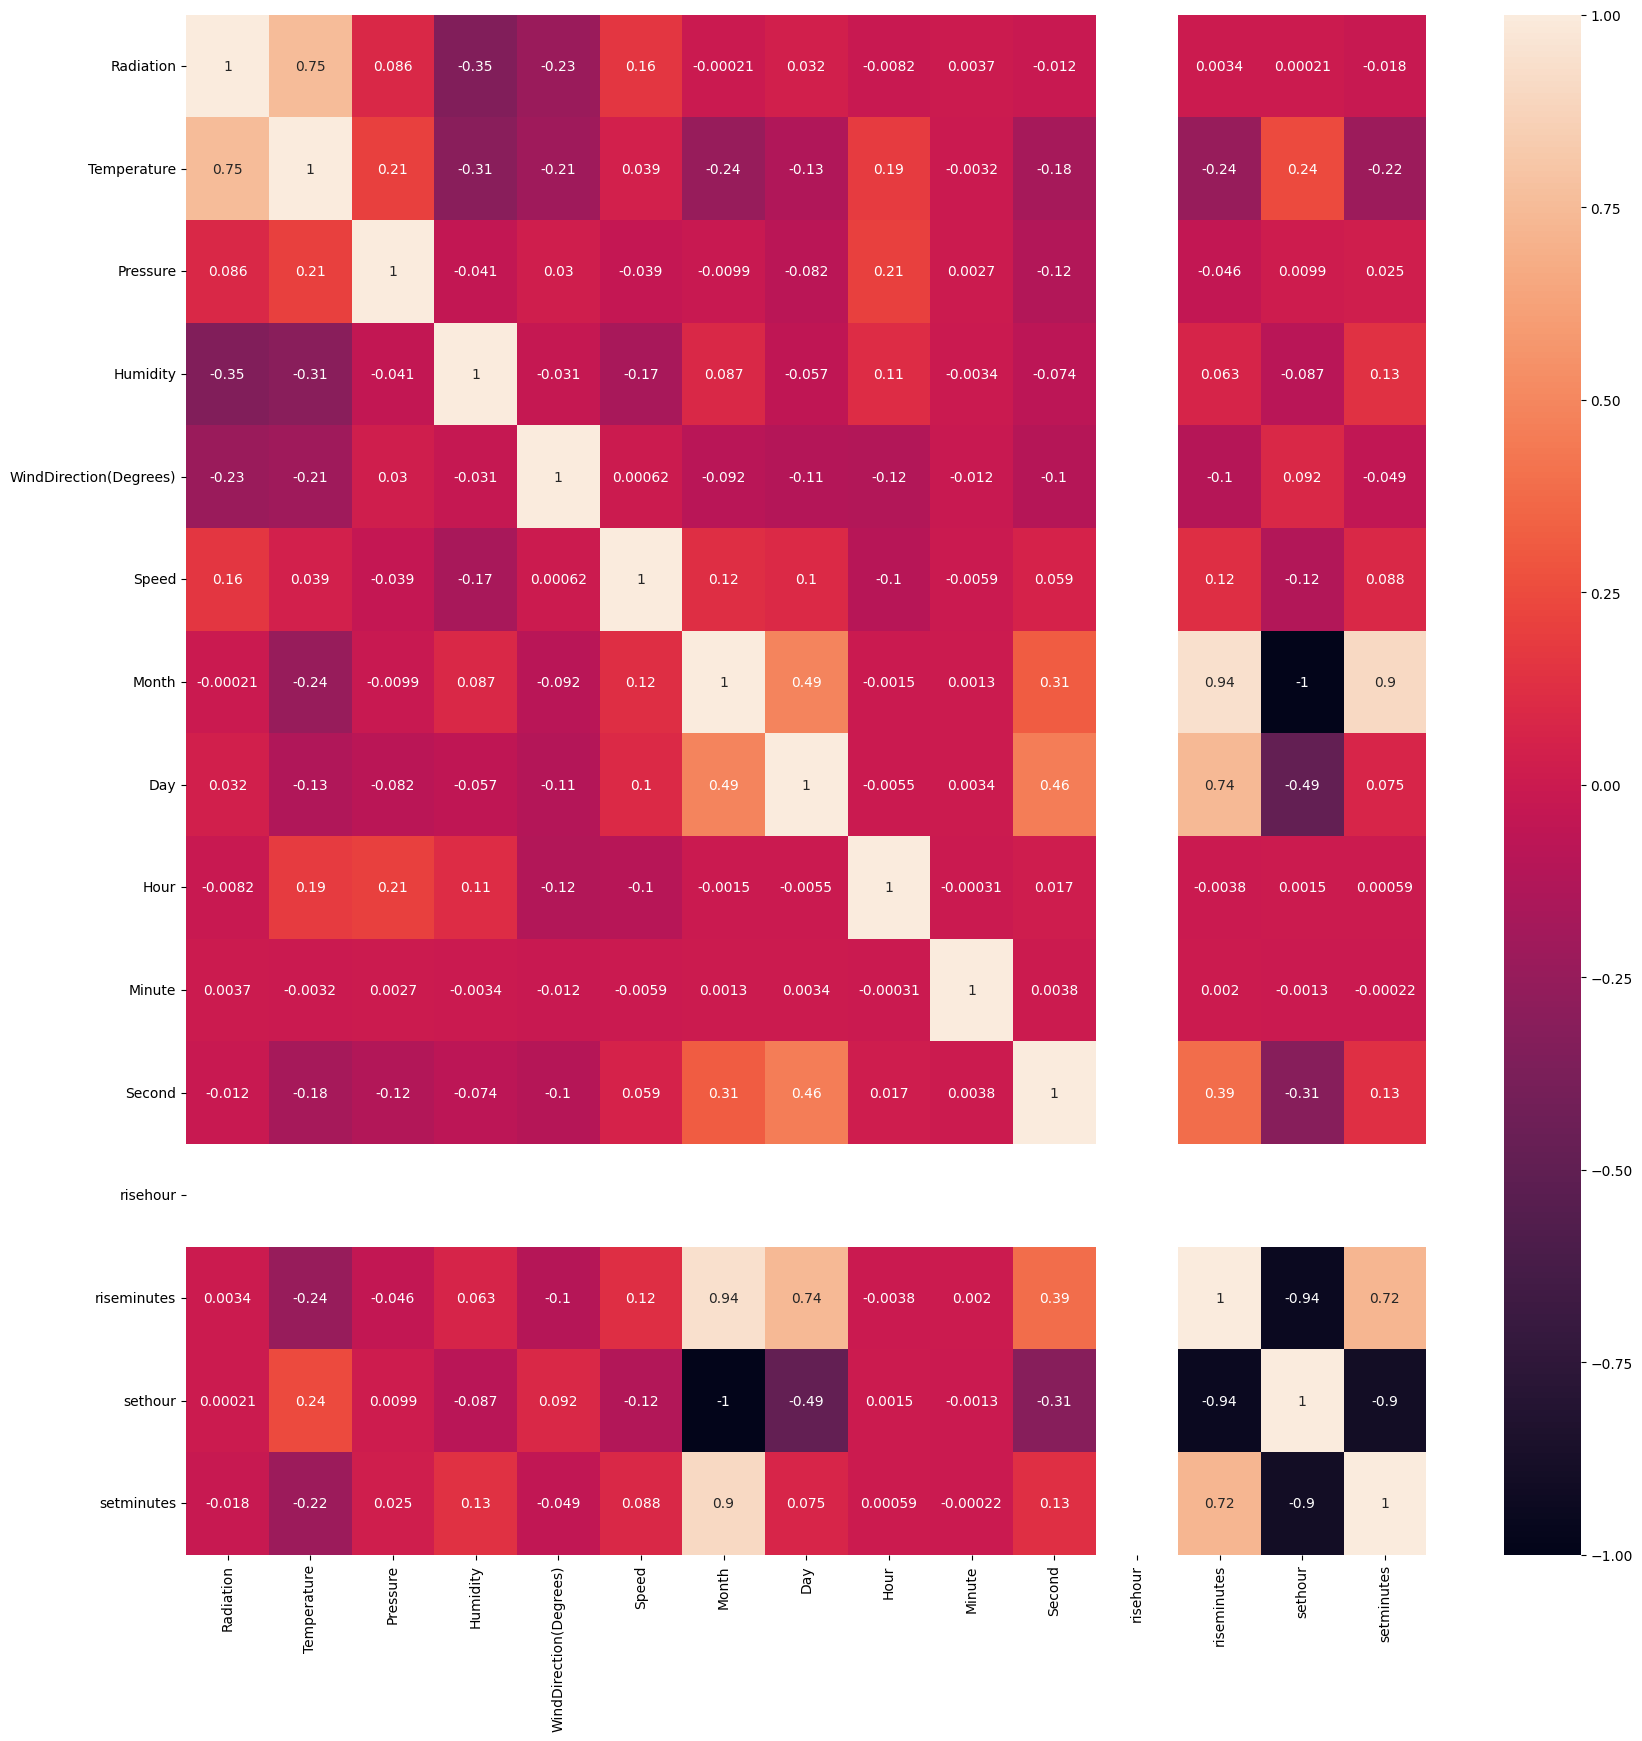

In [ ]:
# plot the correlation matrix using heatmap for clear understanding
plt.figure(figsize=(20,20))
sns.heatmap(df1.corr(), annot=True)
plt.show()

 # Feature Selection using SelectKBest Method

In [ ]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

It works on the target label but instead we are passsing continuous float values to it. So, we need to convert our data to label form usign Label Encoder method and  multiplying the data by 100 and converting it to int which can be treated as labels by the model.



In [ ]:
# use the label encoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [ ]:
target_cont = df1['Radiation'].apply(lambda x : int(x*100))
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [ ]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [ ]:
# contatinating data_features with the scores
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp']

In [ ]:
# best features
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
5,Month,4675.916599
12,sethour,2732.924155
11,riseminutes,2152.354110
13,setminutes,1356.560897
3,WindDirection(Degrees),1315.320285
6,Day,1292.029242
8,Minute,1128.870794
0,Temperature,1023.804229
4,Speed,489.166520
2,Humidity,412.772892


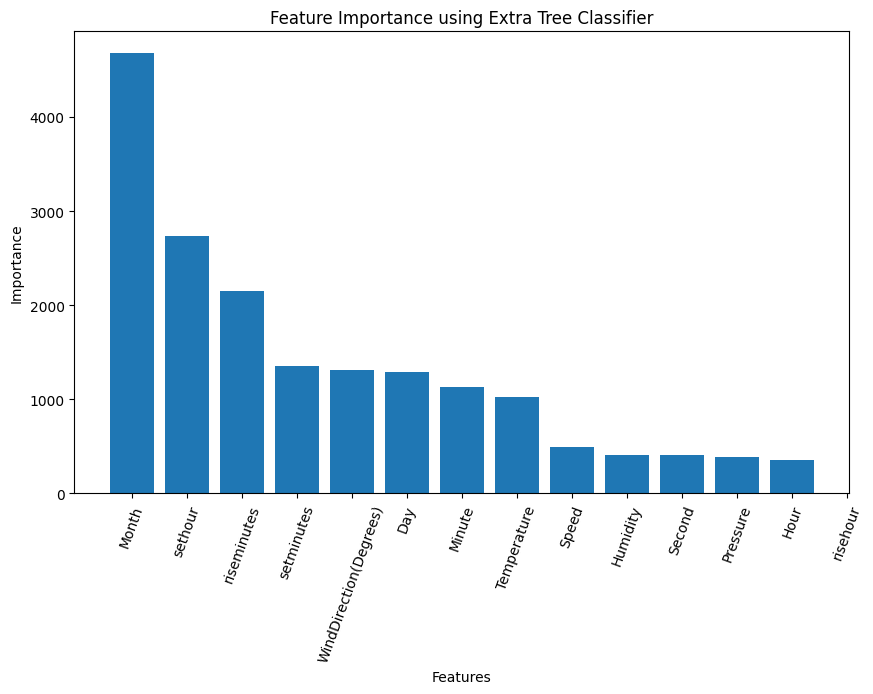

In [ ]:
# visualise the feature importance
plt.figure(figsize = (10, 6))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

 # Feature Selection using Extra Tree Classifier

In [ ]:
model = ExtraTreesClassifier(verbose = 2, n_estimators = 10)
model.fit(scaled_input_features, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


ExtraTreesClassifier(n_estimators=10, verbose=2)

In [ ]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["feature_imp"])
feature_importances.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.163717
Minute,0.151121
Speed,0.124672
Second,0.124519
Humidity,0.115589
Hour,0.091569
Temperature,0.088993
Pressure,0.075237
Day,0.028081
setminutes,0.023928


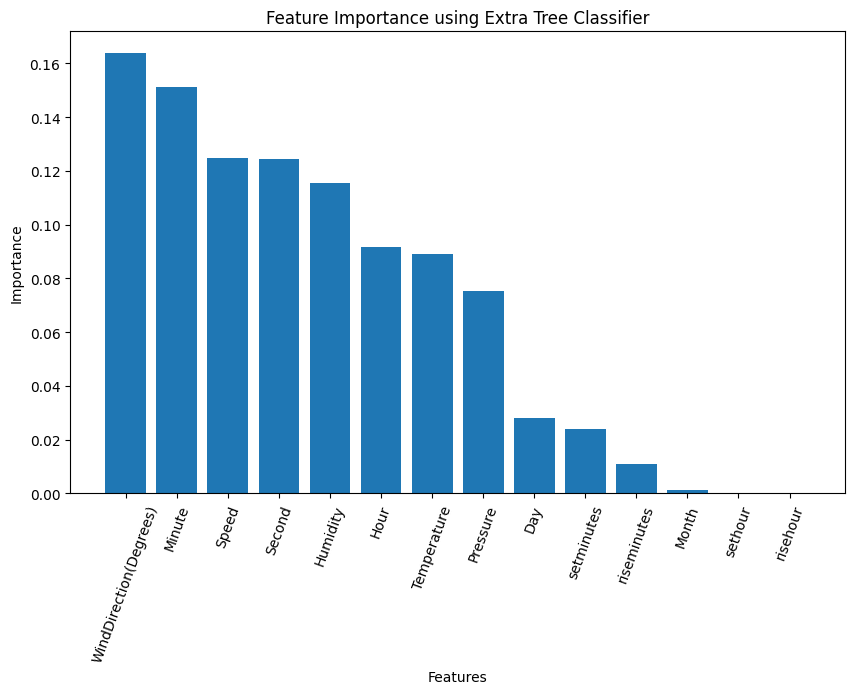

In [ ]:
plt.figure(figsize = (10, 6))
plt.bar(feature_importances.index, feature_importances["feature_imp"])
plt.xticks(rotation = 70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using Extra Tree Classifier")
plt.show()

#Feature Engineering with BoxCox, Log, Min-Max and Standard transformation


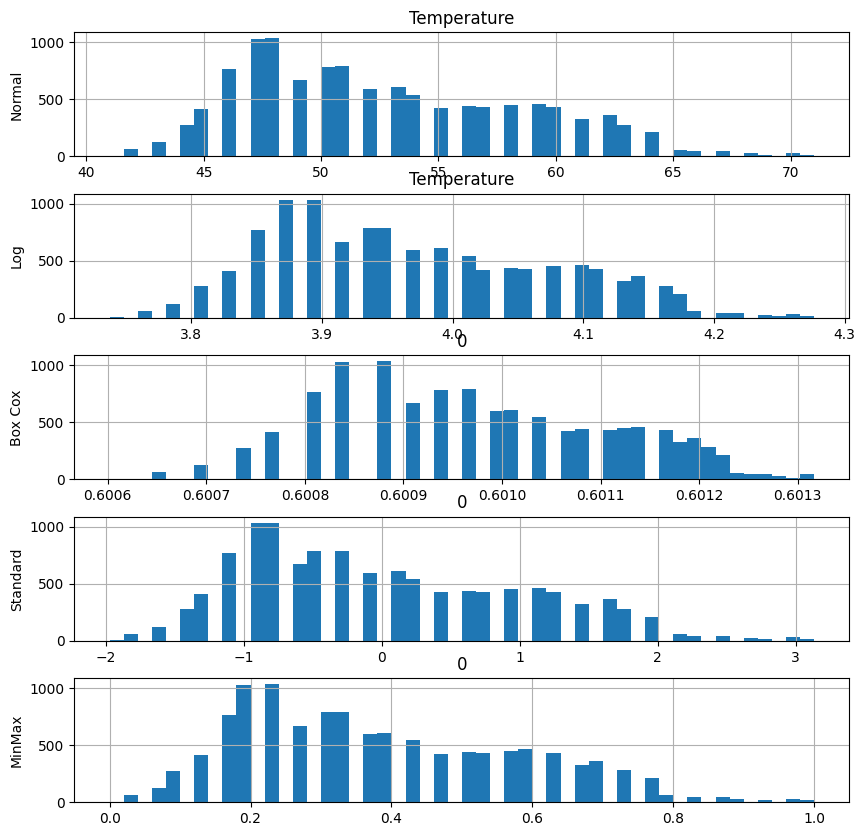

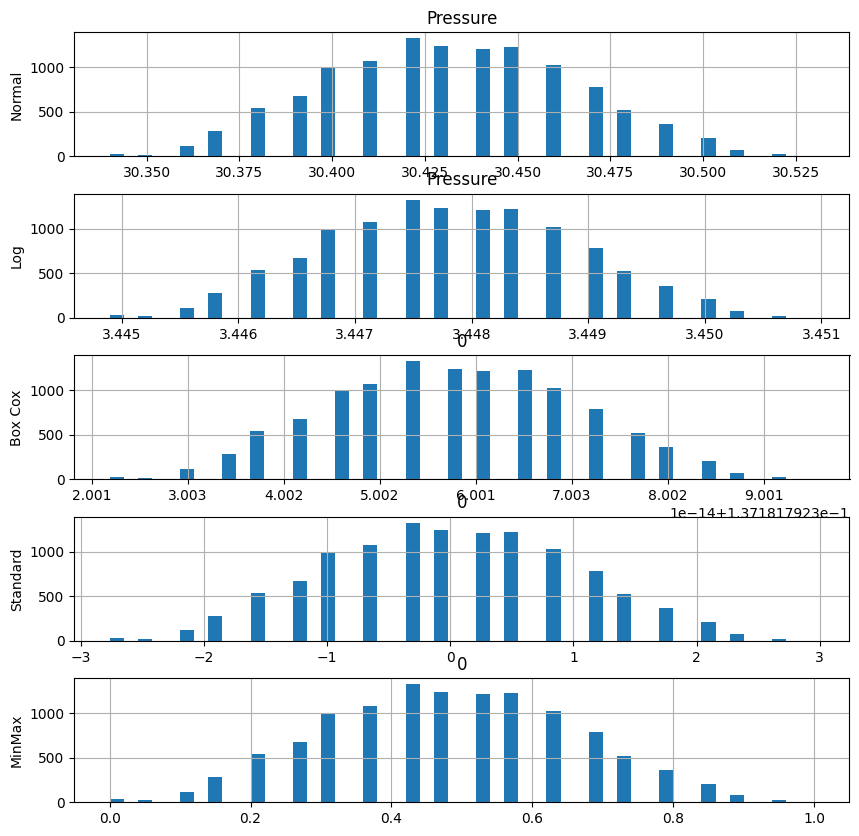

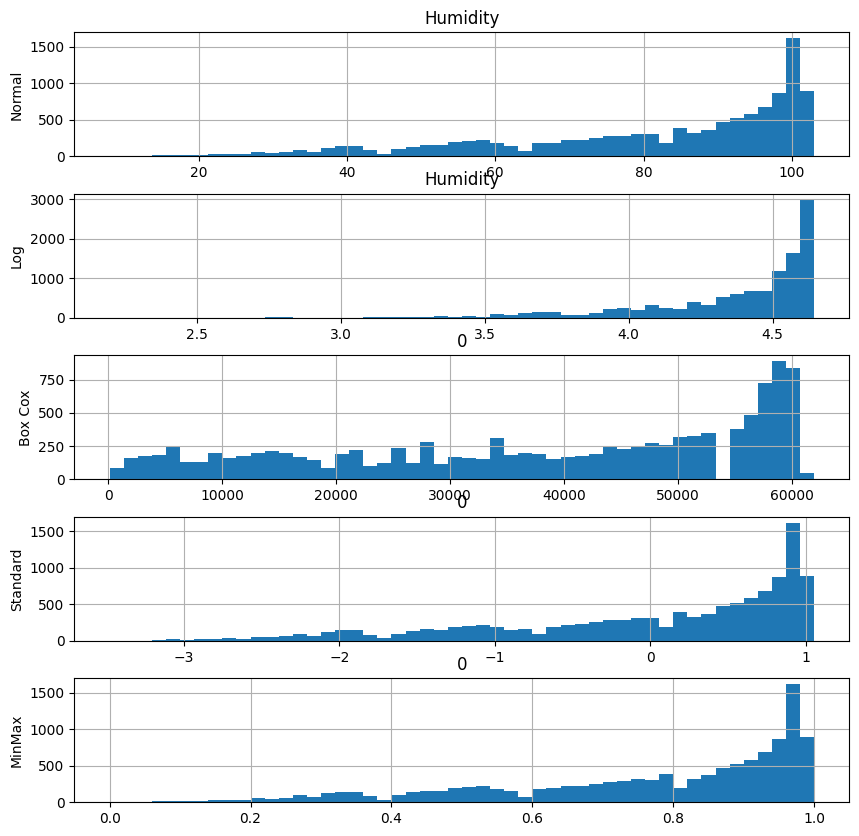

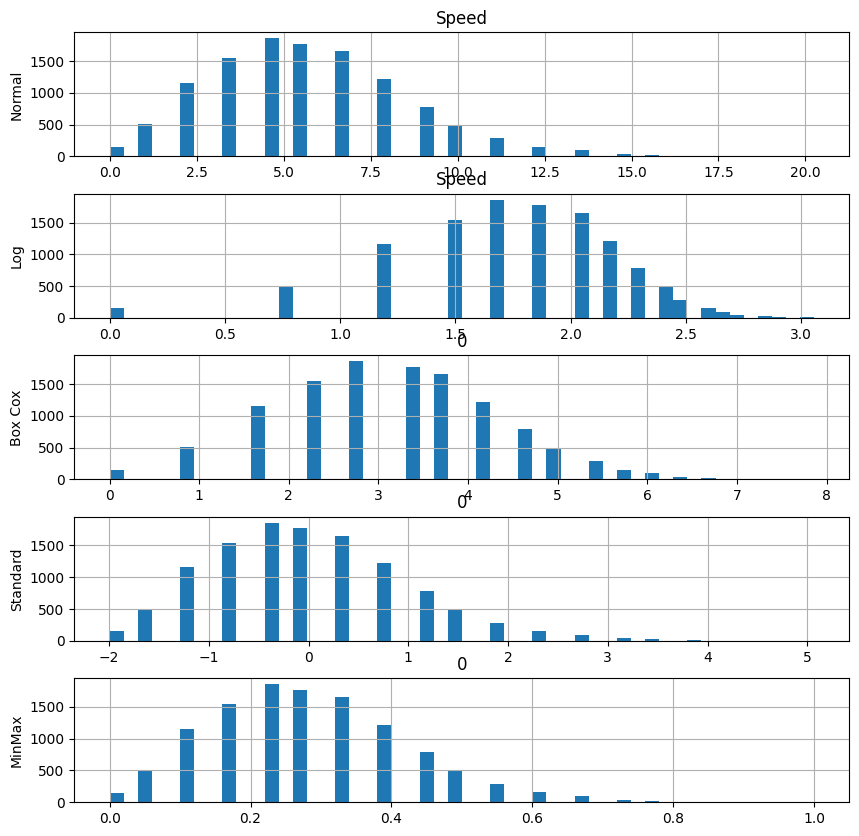

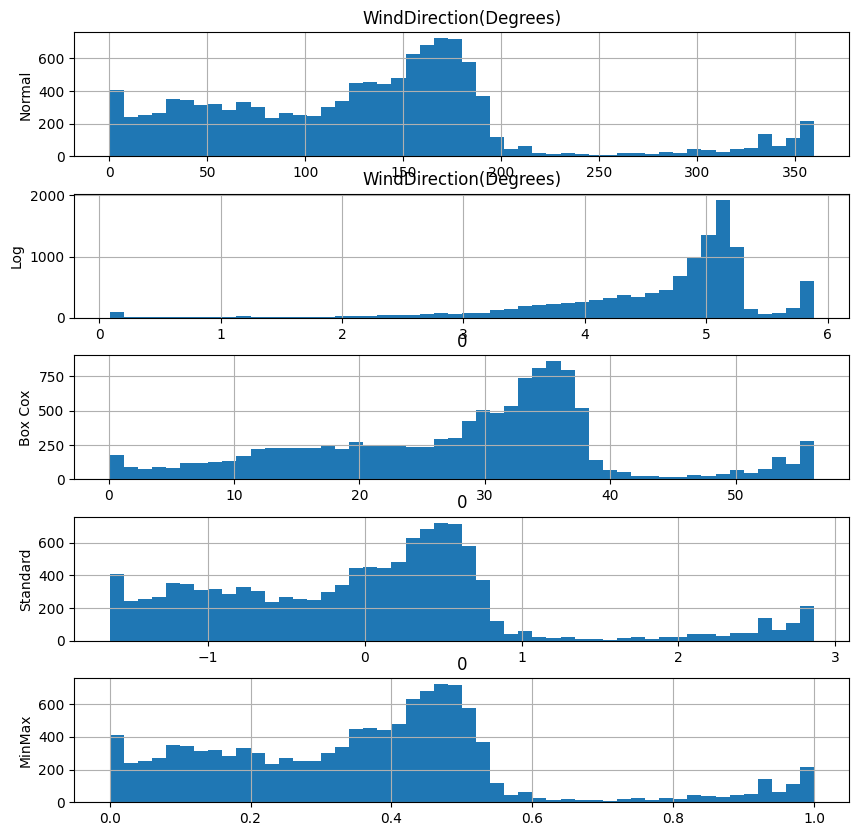

In [ ]:
# Looking for transformation
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 10))

    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')


In [ ]:
# set the transformations required
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log),
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0],
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0],
            'Speed' : (input_features['Speed']+1).transform(np.log),
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
   input_features[i] = transform[i]

In [ ]:
input_features.head()


,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminutes,sethour,setminutes
0,3.89182,0.137182,14990.981483,0.492719,1.890095,9,29,23.0,55.0,26.0,6.0,13.0,18.0,13.0
1,3.89182,0.137182,14354.838190,0.491024,1.474763,9,29,23.0,50.0,23.0,6.0,13.0,18.0,13.0
2,3.89182,0.137182,13735.503580,0.440918,1.474763,9,29,23.0,45.0,26.0,6.0,13.0,18.0,13.0
3,3.89182,0.137182,15644.098086,0.382448,1.474763,9,29,23.0,40.0,21.0,6.0,13.0,18.0,13.0
4,3.89182,0.137182,17001.904015,0.291407,1.890095,9,29,23.0,35.0,24.0,6.0,13.0,18.0,13.0


#Preparing data - Standardisation and Splitting

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [ ]:
xtrain.shape, xtest.shape

((9401, 14), (2351, 14))

#Prediction with XGBoost

In [ ]:
# declare parameters
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [ ]:
# train the model
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(xtest)

In [ ]:
print('XGBoost model result: {0:0.4f}'. format(np.sqrt(mean_squared_error(ytest, y_pred))))

XGBoost model result: 91.2903


In [ ]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 91.29
R2: 0.93


#Using MultiLayer Perceptron for prediction

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [ ]:
model = None
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))

model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [ ]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
265/265 [==============================] - 2s 2ms/step - loss: 172.5234 - mse: 103487.2891 - val_loss: 97.4929 - val_mse: 32911.8164
Epoch 2/50
265/265 [==============================] - 0s 2ms/step - loss: 106.3439 - mse: 39798.6797 - val_loss: 83.5243 - val_mse: 25388.2031
Epoch 3/50
265/265 [==============================] - 0s 2ms/step - loss: 98.9819 - mse: 35628.7461 - val_loss: 77.7780 - val_mse: 22493.9980
Epoch 4/50
265/265 [==============================] - 0s 2ms/step - loss: 95.5684 - mse: 33907.9883 - val_loss: 74.2665 - val_mse: 21430.8281
Epoch 5/50
265/265 [==============================] - 0s 2ms/step - loss: 91.8688 - mse: 31336.8418 - val_loss: 71.3523 - val_mse: 19601.5449
Epoch 6/50
265/265 [==============================] - 0s 2ms/step - loss: 89.7146 - mse: 29784.4102 - val_loss: 69.3564 - val_mse: 18603.7832
Epoch 7/50
265/265 [==============================] - 1s 2ms/step - loss: 87.6804 - mse: 29113.4688 - val_loss: 67.1767 - val_mse: 18160.4043
Epo

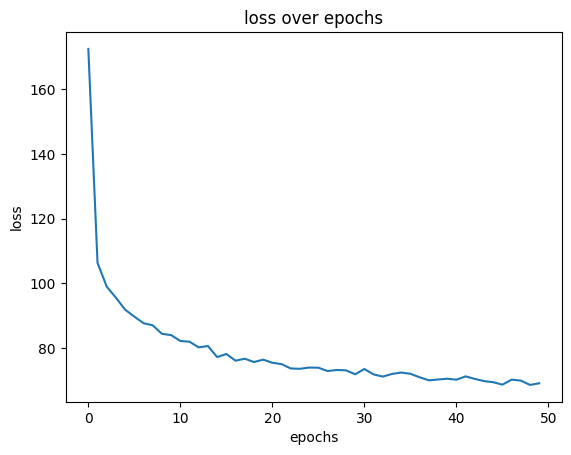

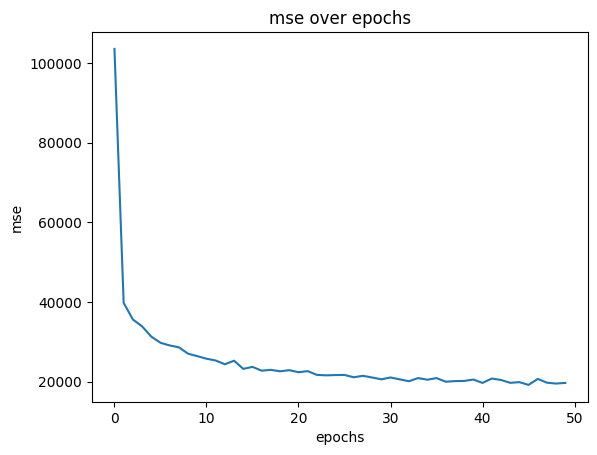

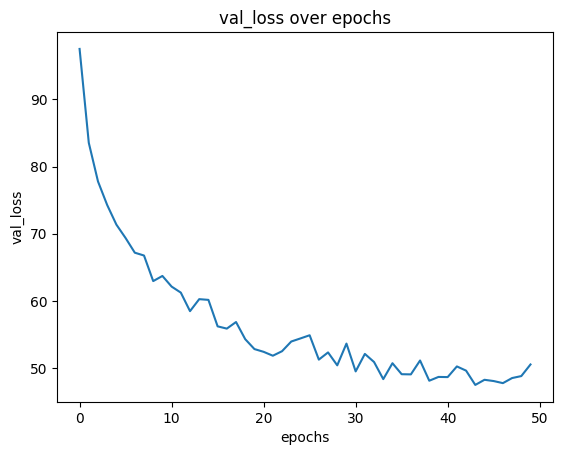

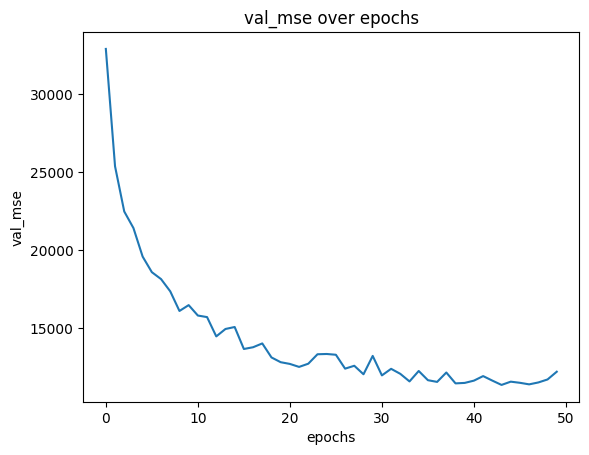

In [ ]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [ ]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

74/74 [==============================] - 0s 1ms/step - loss: 54.8945 - mse: 13086.9658
Mean absolute error:  54.89448928833008


In [ ]:
mean_absolute_error(ytest, model.predict(xtest))

74/74 [==============================] - 0s 896us/step


54.894490273247264